In [1]:
# following issue #5

# Naïve Bayes classifier; simple, out-of-the-box RF;
# simple heuristics e.g. "if a user has more than 4 reviews, it's a real review"

In [2]:
import pickle
import pandas as pd

In [3]:
with open('../data/train_binary_downsampled_data.pckl', 'rb') as f:
    train = pickle.load(f)
with open('../data/dev_binary_downsampled_data.pckl', 'rb') as f:
    dev = pickle.load(f)

In [4]:
reviews = train[:, -2].A
reviews[:5]

array([[29.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.]])

In [5]:
dev_reviews = dev[:, -2].A
dev_reviews[:5]

array([[ 0.],
       [ 7.],
       [ 0.],
       [ 3.],
       [16.]])

In [6]:
ratings = train[:, -1].A
ratings[:5]

array([[3.],
       [3.],
       [4.],
       [4.],
       [4.]])

In [7]:
dev_ratings = dev[:, -1].A
dev_ratings[:5]

array([[5.],
       [4.],
       [5.],
       [4.],
       [3.]])

In [8]:
with open('../data/train_labels.pckl', 'rb') as f:
    train_labels = pickle.load(f)

with open('../data/dev_labels.pckl', 'rb') as f:
    dev_labels = pickle.load(f)

## Majority class classifier

In [9]:
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score

majority_train = np.zeros(train_labels.shape)
majority_dev = np.zeros(dev_labels.shape)

majority_train_auc = roc_auc_score(train_labels, majority_train)
majority_train_ap = average_precision_score(train_labels, majority_train)
majority_dev_auc = roc_auc_score(dev_labels, majority_dev)
majority_dev_ap = average_precision_score(dev_labels, majority_dev)

print(f'Simple majority baseline')
print(f'Train AUC: {majority_train_auc:.4f}\n'
      f'Dev   AUC: {majority_dev_auc:.4f}\n'
      f'Train AP:  {majority_train_ap:.4f}\n'
      f'Dev   AP:  {majority_dev_ap:.4f}')

Simple majority baseline
Train AUC: 0.5000
Dev   AUC: 0.5000
Train AP:  0.5000
Dev   AP:  0.1016


In [10]:
dev_labels.mean()

0.101564675093268

## Heuristics classifier

In [11]:
train_df = pd.DataFrame(zip(reviews.flatten(),
                            ratings.flatten(),
                            train_labels),
                        columns=['review count', 'rating', 'label'])
dev_df = pd.DataFrame(zip(dev_reviews.flatten(),
                          dev_ratings.flatten(),
                          dev_labels),
                      columns=['review count', 'rating', 'label'])

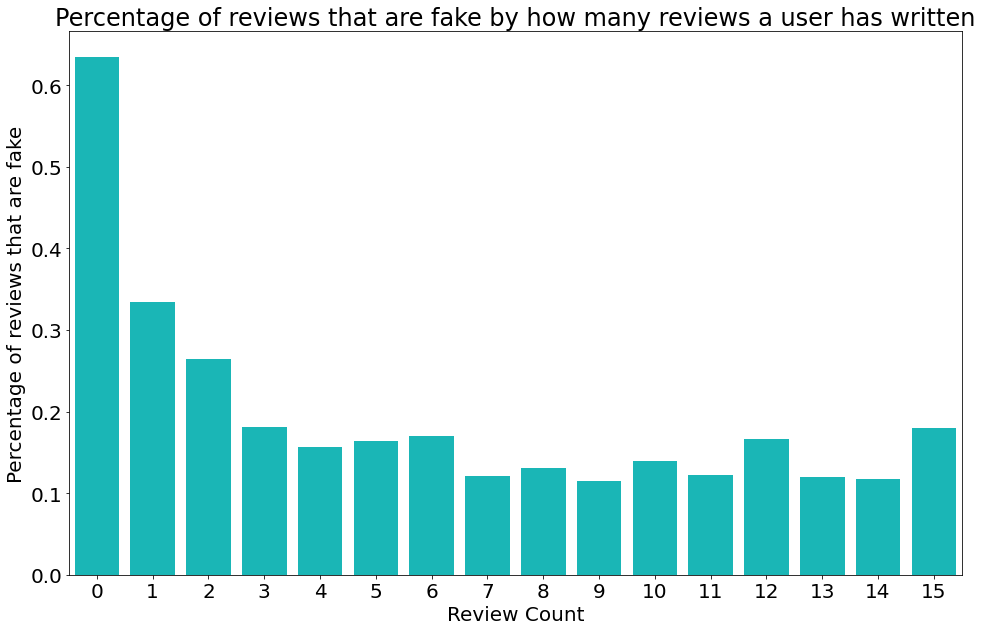

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
train_grouped = train_df.groupby(['review count'], as_index=False).agg({'label': 'mean'})
train_grouped['review count'] = train_grouped['review count'].astype(int)
sns.barplot(x='review count', y='label', data=train_grouped, palette=['#00D0D0'])
#plt.plot([0, 15], [0.2, 0.2], 'k--')  # dashed line at 2%
plt.xlabel('Review Count')
plt.ylabel('Percentage of reviews that are fake')
plt.title('Percentage of reviews that are fake by how many reviews a user has written')
plt.xlim([-0.5, 15.5])
plt.savefig('../graphs/fake-by-count.png')

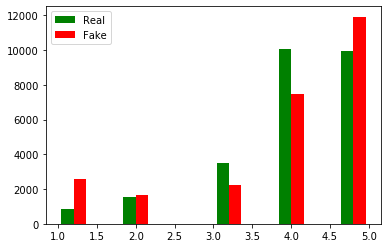

In [13]:
plt.hist([train_df[train_df['label'] == 0]['rating'],
          train_df[train_df['label'] == 1]['rating'],
          ],
         color=['g', 'r'],
         label=['Real', 'Fake']
         )
plt.legend()

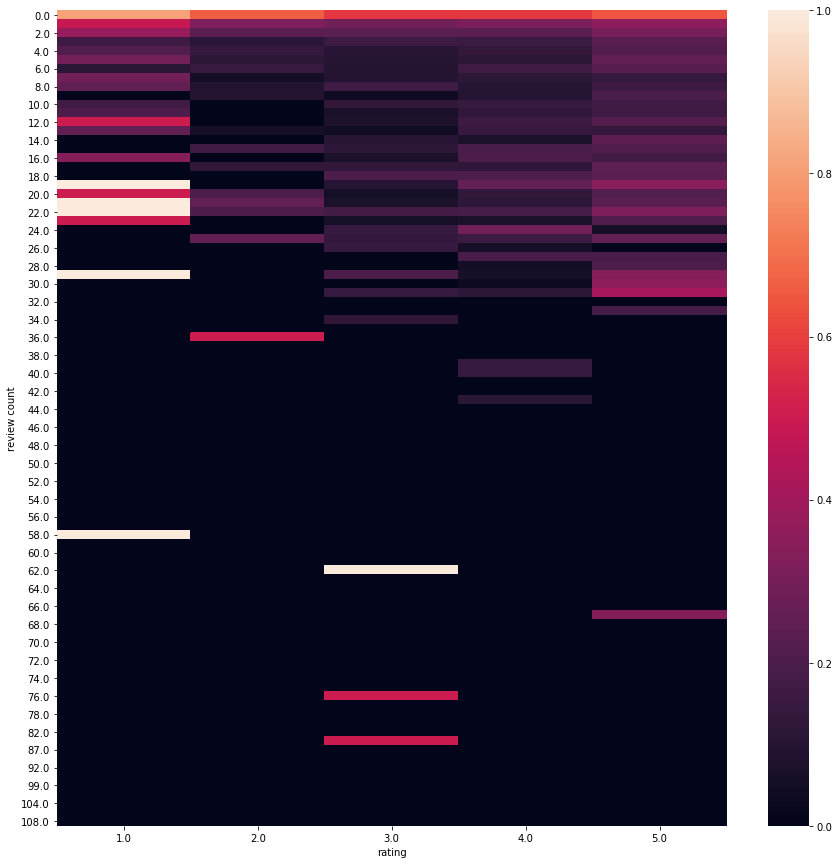

In [14]:
review_x_rating = train_df.groupby(['review count', 'rating']).agg({'label': 'mean'})
review_x_rating = (review_x_rating.unstack()  # unstack
                   .fillna(0)
                   .T.reset_index(level=0, drop=True)  # drop useless index
                   .T  # fix transpose
                   )
plt.figure(figsize=(15, 15))
sns.heatmap(review_x_rating)

In [15]:
# simple heuristics classifier

def heuristic_baseline(a, x):
    return (x['review count'] <= a).astype(int)

for i in range(6):
    heuristic_train = heuristic_baseline(i, train_df)
    heuristic_dev = heuristic_baseline(i, dev_df)

    heuristic_train_auc = roc_auc_score(train_labels, heuristic_train)
    heuristic_dev_auc = roc_auc_score(dev_labels, heuristic_dev)
    heuristic_train_ap = average_precision_score(train_labels, heuristic_train)
    heuristic_dev_ap = average_precision_score(dev_labels, heuristic_dev)

    print(f'Simple heuristic baseline for {i}')
    print(f'Train AUC: {heuristic_train_auc:.4f}\n'
          f'Dev   AUC: {heuristic_dev_auc:.4f}\n'
          f'Train AP:  {heuristic_train_ap:.4f}\n'
          f'Dev   AP:  {heuristic_dev_ap:.4f}')

Simple heuristic baseline for 0
Train AUC: 0.6809
Dev   AUC: 0.6797
Train AP:  0.6147
Dev   AP:  0.1543
Simple heuristic baseline for 1
Train AUC: 0.6477
Dev   AUC: 0.6491
Train AP:  0.5880
Dev   AP:  0.1398
Simple heuristic baseline for 2
Train AUC: 0.6242
Dev   AUC: 0.6235
Train AP:  0.5715
Dev   AP:  0.1310
Simple heuristic baseline for 3
Train AUC: 0.6035
Dev   AUC: 0.6047
Train AP:  0.5580
Dev   AP:  0.1253
Simple heuristic baseline for 4
Train AUC: 0.5886
Dev   AUC: 0.5892
Train AP:  0.5488
Dev   AP:  0.1211
Simple heuristic baseline for 5
Train AUC: 0.5777
Dev   AUC: 0.5769
Train AP:  0.5422
Dev   AP:  0.1179


In [16]:
res = review_x_rating.stack().reset_index()
res.columns = ['review count', 'rating', 'avg label']

In [17]:
# other heuristic

trained = pd.merge(train_df, res, on=['review count', 'rating'], how='left')
trained.fillna(0, inplace=True)
trained['fake'] = (trained['avg label'] >= 0.5).astype(int)

dev_trained = pd.merge(dev_df, res, on=['review count', 'rating'], how='left')
dev_trained.fillna(0, inplace=True)
dev_trained['fake'] = (dev_trained['avg label'] >= 0.5).astype(int)

heuristic_train_auc = roc_auc_score(train_labels, trained['fake'])
heuristic_dev_auc = roc_auc_score(dev_labels, dev_trained['fake'])
heuristic_train_ap = average_precision_score(train_labels, trained['fake'])
heuristic_dev_ap = average_precision_score(dev_labels, dev_trained['fake'])

print(f'Other heuristic baseline')
print(f'Train AUC: {heuristic_train_auc:.4f}\n'
      f'Dev   AUC: {heuristic_dev_auc:.4f}\n'
      f'Train AP:  {heuristic_train_ap:.4f}\n'
      f'Dev   AP:  {heuristic_dev_ap:.4f}')

Other heuristic baseline
Train AUC: 0.6810
Dev   AUC: 0.6796
Train AP:  0.6148
Dev   AP:  0.1542


In [18]:
# so much work.... for nothing

## NB Classifier

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
nb = MultinomialNB()  # standard laplace smoothing is fine
nb.fit(train, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
nb_train = nb.predict(train)
nb_dev = nb.predict(dev)

In [22]:
nb_train_auc = roc_auc_score(train_labels, nb_train)
nb_dev_auc = roc_auc_score(dev_labels, nb_dev)
nb_train_ap = average_precision_score(train_labels, nb_train)
nb_dev_ap = average_precision_score(dev_labels, nb_dev)

print('NB baseline')
print(f'Train AUC: {nb_train_auc:.4f}\n'
      f'Dev   AUC: {nb_dev_auc:.4f}\n'
      f'Train AP:  {nb_train_ap:.4f}\n'
      f'Dev   AP:  {nb_dev_ap:.4f}')

NB baseline
Train AUC: 0.9797
Dev   AUC: 0.6298
Train AP:  0.9704
Dev   AP:  0.1553


In [23]:
# higher is better:
average_precision_score(train_labels, train_labels)

1.0

## RF Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
# i would like to finish training someday soon
rf = RandomForestClassifier(n_estimators=48,
                            random_state=0,
                            n_jobs=-1,
                            max_features='log2',
                            verbose=1,
                            max_depth=4000,
                            )

rf.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4000, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=48, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [26]:
rf_train = rf.predict(train)
rf_dev = rf.predict(dev)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed:    8.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed:    5.7s finished


In [27]:
rf_train_auc = roc_auc_score(train_labels, rf_train)
rf_dev_auc = roc_auc_score(dev_labels, rf_dev)
rf_train_ap = average_precision_score(train_labels, rf_train)
rf_dev_ap = average_precision_score(dev_labels, rf_dev)

print('RF baseline')
print(f'Train AUC: {rf_train_auc:.4f}\n'
      f'Dev   AUC: {rf_dev_auc:.4f}\n'
      f'Train AP:  {rf_train_ap:.4f}\n'
      f'Dev   AP:  {rf_dev_ap:.4f}')

RF baseline
Train AUC: 0.9427
Dev   AUC: 0.5820
Train AP:  0.8971
Dev   AP:  0.1194
